In [1]:
import sqlite3
import pandas as pd
import nltk
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    PER,
    NamesExtractor,
    Doc
)
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

nltk.download(['averaged_perceptron_tagger_ru', 'stopwords', 'punkt'])
    
import matplotlib.pyplot as plt

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     C:\Users\Масленок\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_ru.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Масленок\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Масленок\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [5]:
cur = sqlite3.connect('golden.db')
df = pd.read_sql_query('SELECT * FROM golden', cur)
cur.close()
df

,title,content,category,created_date
0,«Полис недоступности» и «красные зоны»: Правит...,"Во Владивостоке прошло совещание, посвящённое ...",Политика;Экономика,22.Мар.2023
1,Лишение депутатских полномочий случилось на Ка...,"…И случилось не само по себе, а по иску прокур...",Закон;Политика,21.Мар.2024
2,В районе улицы Толстого реконструкция дороги и...,Во Владивостоке активно продолжается политика ...,Политика;Репортаж,26.Май.2023
3,Владивостокская таможня – не место для заторов,О двукратном уменьшении количества досмотров к...,Политика;Экономика,24.Мар.2023
4,Глава Приморья освободил от должности руководи...,Директора филиалов «Надеждинский» и «Хасанский...,Политика;Экономика,07.Авг.2023
...,...,...,...,...
58,Работница КГБУЗ “Красноармейская ЦРБ” восстано...,,Политика;Экономика,15.Окт.2022
59,«Битва» за 392 млн рублей «лесных» денег в При...,09 ноября 2022 года состоялось очередное засед...,Политика;Экономика,14.Ноя.2022
60,Инжиниринговая «перепутаница» не «по-Чуковском...,В январе 2014 года во Владивостоке появилась к...,Политика;Экономика,27.Окт.2022
61,На Дальнем Востоке выявили 52 «чёрных кредитор...,За девять месяцев 2022 года Банк России выявил...,Политика;Экономика,07.Ноя.2022


# Подготовка данных

In [6]:
data = list(df['content'])
data[:1]

['Во Владивостоке прошло совещание, посвящённое транспортным проблемам, под председательством вице-губернатора Николая Стецко. Главным вопросом стало нахождение Приморского края в так называемой «красной зоне», куда Российский союз автостраховщиков (РСА) включает регионы, если в них зафиксирован рост ДТП и большие суммы взысканий за ущерб по полисам обязательного страхования автогражданской ответственности (ОСАГО). Из-за того, что регион (в нашем случае это Приморский край) внесён в «красную зону», страховые компании могут уйти из региона, что и приводит к тому, что вот уже около 5 лет автовладельцам Приморья достаточно трудно приобрести полис ОСАГО. При попытке сделать этой онлайн система показывает сбой, а при попытке купить полис через страховую компанию возникает «накрутка» за услуги посредников 1,5-2 тысячи рублей, но даже этот вариант не всегда даёт возможность своевременно приобрести полис «автогражданки». Страдают от этой ситуации как простые граждане, так и представители бизне

In [7]:
for text in range(len(data)):
        data[text] = ' '.join([token for token in nltk.word_tokenize(data[text]) if token not in nltk.corpus.stopwords.words('russian')]).replace(' .', '.')
data[1]

'…И случилось само , иску прокуратуры Тигильского района , которая провела проверку исполнения законодательства противодействии коррупции. Об сообщил Telegram-канал надзорного ведомства Камчатского края.Так , результате проверки выяснилось , « депутат Собрания депутатов муниципального образования « Тигильский муниципальный район » рассмотрении очередной сессии вопроса размерах оплаты труда муниципальных служащих , число которых руководящей должности входила её близкая родственница , мер самоотводу приняла , голосовала общем порядке ».Этот факт побудил прокуратуру внести орган местного самоуправления представление. Но оно отклонено : депутаты сочли , нарушения антикоррупционного законодательства имелось. Что касается « героини » скандальной истории , сама подала заявление добровольном сложении полномочий , отставка принята.Но тут-то : прокурор , согласившись представительным органом местного самоуправления , обратился суд заявлением – , признать факт бездействия районного Собрания депут

In [8]:
text = data[3]
doc = Doc(text)
doc.segment(segmenter)
doc.parse_syntax(syntax_parser)
doc.tag_morph(morph_tagger)
for sentence in doc.sents: # получаем предложения
    try:
        sentence.syntax.print()
    except:
        print()

      ┌──► О               case
      │ ┌► двукратном      amod
┌────►└─└─ уменьшении      obl
│   ┌─└──► количества      nmod
│   │   ┌► досмотров       amod
│ ┌─└──►└─ контейнеров     nmod
│ │     ┌► Владивостокской amod
│ └────►└─ таможне         nmod
│       ┌► полуторакратном amod
│   ┌►┌─└─ сокращении      obl
│   │ └►┌─ срока           nmod
│   │ ┌─└► проведения      nmod
│   │ └──► досмотра        nmod
└─┌─└───┌─ сообщил         
  │   ┌─└► Telegram-канал  nsubj
  │   └►┌─ ФТС             nmod
  │     └► России          nmod
  └──────► .               punct
                                                              ┌──► По                       case
                                                              │ ┌► этим                     det
                                                        ┌────►└─└─ данным                   parataxis
                                                        │     └──► ,                        punct
        ┌──────►┌──────────────────

# Токенизация

In [9]:
tokens_arr = []
for text in data:
    doc = Doc(text)
    doc.segment(segmenter)
    tokens_arr.append(doc)
tokens_arr[1]

Doc(text='…И случилось само , иску прокуратуры Тигильского ..., tokens=[...], sents=[...])

# Лематизация

In [10]:
for doc in tokens_arr:
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)

tokens_arr[1].tokens[:5]


[DocToken(stop=1, text='…', pos='PUNCT', lemma='…'),
 DocToken(start=1, stop=2, text='И', pos='CCONJ', lemma='и'),
 DocToken(start=3, stop=12, text='случилось', pos='VERB', feats=<Perf,Neut,Ind,Sing,Past,Fin,Mid>, lemma='случиться'),
 DocToken(start=13, stop=17, text='само', pos='ADJ', feats=<Nom,Pos,Neut,Sing>, lemma='сам'),
 DocToken(start=18, stop=19, text=',', pos='PUNCT', lemma=',')]

# Самые популярные пары подлежащих и сказуемых

In [11]:
popular = {}
for doc in tokens_arr:
    doc.parse_syntax(syntax_parser)
    for sentence in doc.sents:
        root = {}
        nsubj = {}

        for token in sentence.tokens:
            if token.rel == 'root':
                root[token.id] = token.lemma
            if token.rel == 'nsubj':
                nsubj[token.id] = (token.head_id, token.lemma)

        for key, value in nsubj.items():
            try:
               pop = f'{root[value[0]]} + {value[1]}'
               if pop not in popular.keys():
                   popular[pop] = 0
               popular[pop] += 1
            except:
                continue

In [12]:
maximum = []
m = max(popular.values())
for key, value in popular.items():
    if value == m or value == m-1:
        maximum.append(key)
print(maximum)


['сообщить + telegram-канал', 'состояться + форум']


# Самые популярные слова

In [13]:
popularWord = {}
for doc in tokens_arr:
    for token in doc.tokens:
        if token.rel == 'punct':
            continue
        if token.lemma not in popularWord.keys():
            popularWord[token.lemma] = 0
        popularWord[token.lemma] += 1


# Статистика

,Группа,Количество
67,состояться + форум,10
24,сообщить + telegram-канал,10
47,чистый + совесть,5
53,план + это,5
52,заявить + итог,5
...,...,...
151,нести + арендатор,1
152,сторона + это,1
153,сторона + подрядчик,1
154,сторона + минлесхоз,1


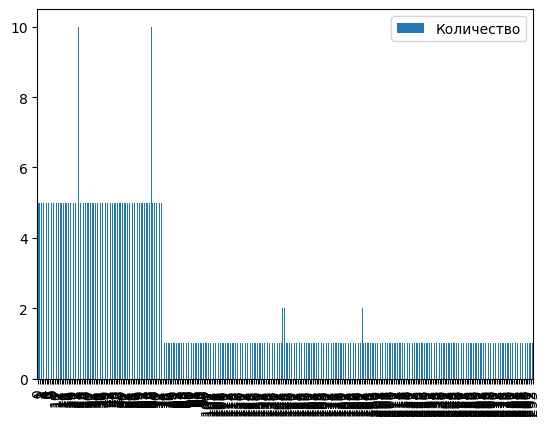

In [14]:
df = pd.DataFrame(popular.items(), columns=['Группа', "Количество"])
display(df.sort_values(by='Количество', ascending=False))
df.plot.bar()
plt.show()

,0,1
52,год,88
45,компания,84
15,приморский,70
16,край,66
122,который,56
...,...,...
1319,нашуметь,1
1320,разом,1
1321,потерять,1
1322,всякий,1


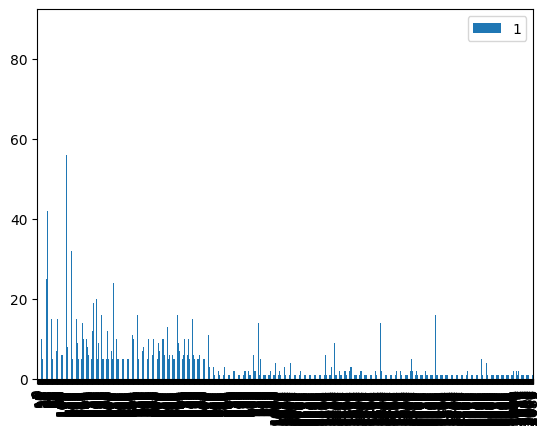

In [15]:
df = pd.DataFrame(popularWord.items())
display(df.sort_values(by=1, ascending=False))
df.plot.bar()
plt.show()

Данные статьи, судя по статистике, являются экономически-политичсекими новостями Приморского края. Отсюда и закономерность, что сочетание "форум состояться" встречается чаще всего. 
С точки зрения предметной области моей деятельности (SEO-специалист), я могу отметить, что данный способ выделения популярных фраз позволяет выделить фразы, которые помогают продвижению сайта, что поможет использовать те же фишки и слова в своей деятельности. 
При этом, за исключением слов-ключей, в основном они не повторяются, за исключением географических и "кричащих" слов.